In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tgs-salt-identification-challenge/depths.csv
/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv
/kaggle/input/tgs-salt-identification-challenge/train.zip
/kaggle/input/tgs-salt-identification-challenge/competition_data.zip
/kaggle/input/tgs-salt-identification-challenge/test.zip
/kaggle/input/tgs-salt-identification-challenge/train.csv
/kaggle/input/tgs-salt-identification-challenge/flamingo.zip


In [2]:
# ===========================================
# Step 0: Import Libraries & Set Seeds
# ===========================================
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
import random
from PIL import Image
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import time 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# --- For Reproducibility ---
SEED = 42
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if using multi-GPU
    # These are needed for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print("Libraries imported and seed set.")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Libraries imported and seed set.


In [3]:
# ===========================================
# Step 1: Define Data Augmentations
# ===========================================
# Define image size
IMG_SIZE = 128 # U-Net works well with powers of 2

# Training augmentations
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Validation/Test augmentations
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
print("Augmentations defined.")

Augmentations defined.


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
# ===========================================
# Step 2: Define UNet Model (Encoder + Decoder)
# ===========================================
class ResNetEncoder(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True):
        super().__init__()
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        if backbone_name == 'resnet34':
            backbone = models.resnet34(weights=weights)
            channels = [64, 64, 128, 256, 512]
        elif backbone_name == 'resnet50':
            weights = models.ResNet50_Weights.DEFAULT if pretrained else None
            backbone = models.resnet50(weights=weights)
            channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError("Unsupported backbone")

        self.channels = channels
        self.initial = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.encoder1 = backbone.layer1
        self.encoder2 = backbone.layer2
        self.encoder3 = backbone.layer3
        self.encoder4 = backbone.layer4

    def forward(self, x):
        x0 = self.initial(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        return x0, x1, x2, x3, x4

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
             x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNet(nn.Module):
    def __init__(self, backbone_name='resnet34', pretrained=True, n_classes=1):
        super().__init__()
        self.encoder = ResNetEncoder(backbone_name, pretrained)
        channels = self.encoder.channels

        self.decoder4 = DecoderBlock(channels[4], channels[3], 256)
        self.decoder3 = DecoderBlock(256, channels[2], 128)
        self.decoder2 = DecoderBlock(128, channels[1], 64)
        self.decoder1 = DecoderBlock(64, channels[0], 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        input_size = x.shape[2:]
        x0, x1, x2, x3, x4 = self.encoder(x)
        d4 = self.decoder4(x4, x3)
        d3 = self.decoder3(d4, x2)
        d2 = self.decoder2(d3, x1)
        d1 = self.decoder1(d2, x0)
        out = self.final_conv(d1)
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
        return out

print("U-Net Model defined.")

U-Net Model defined.


In [5]:
# ===========================================
# Step 3: Loss Functions
# ===========================================
class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = StableBCELoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)  # no sigmoid here!
        probs = torch.sigmoid(logits)         # apply sigmoid separately for dice
        intersection = (probs * targets).sum()
        dice_loss = 1 - (2. * intersection + 1e-6) / (probs.sum() + targets.sum() + 1e-6)
        return bce_loss + dice_loss
def mean(l, ignore_nan=False, empty=0):
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss
def lovasz_hinge_flat(logits, labels, ignore=None):
    if ignore is None:
        logits, labels = logits.view(-1), labels.view(-1)
    else:
        mask = (labels != ignore)
        logits, labels = logits[mask], labels[mask]
    signs = 2. * labels.float() - 1.
    errors = 1. - logits * signs
    errors_sorted, perm = torch.sort(errors, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss
def flatten_binary_scores(scores, labels, ignore=None):
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    return scores[valid], labels[valid]

class LovaszLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        logits = logits.squeeze(1)  # (B,1,H,W) -> (B,H,W)
        targets = targets.squeeze(1)
        return lovasz_hinge(logits, targets)

class ComboLoss(nn.Module):
    def __init__(self, weight_bce_dice=0.5, weight_lovasz=0.5):
        super().__init__()
        self.bce_dice = BCEDiceLoss()
        self.lovasz = LovaszLoss()
        self.w1 = weight_bce_dice
        self.w2 = weight_lovasz

    def forward(self, logits, targets):
        loss1 = self.bce_dice(logits, targets)
        loss2 = self.lovasz(logits, targets)
        return self.w1 * loss1 + self.w2 * loss2
print("Loss functions defined.")

Loss functions defined.


In [8]:
# ===========================================
# Step 4: Data Loading, Filtering, and Split
# ===========================================
# --- Unzip Data ---
import os
import zipfile
import shutil

# Define paths
train_zip_path = '/kaggle/input/tgs-salt-identification-challenge/train.zip'
test_zip_path = '/kaggle/input/tgs-salt-identification-challenge/test.zip'
working_dir = '/kaggle/working/'

# Check current working directory contents
print("Before extraction, working directory contains:", os.listdir(working_dir))

# Temporary extraction directory
temp_dir = os.path.join(working_dir, 'temp_extract')
os.makedirs(temp_dir, exist_ok=True)

# Extract and organize train data
if not os.path.exists(os.path.join(working_dir, 'train')):
    print("Extracting train.zip...")
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    
    # Create train directory
    os.makedirs(os.path.join(working_dir, 'train'), exist_ok=True)
    
    # Move extracted content to train directory
    for item in os.listdir(temp_dir):
        src = os.path.join(temp_dir, item)
        dst = os.path.join(working_dir, 'train', item)
        shutil.move(src, dst)
    
    print("Train.zip extracted and organized!")
else:
    print("Train directory already exists.")

# Clean up temp directory
if os.path.exists(temp_dir):
    os.rmdir(temp_dir)

# Extract and organize test data
temp_dir = os.path.join(working_dir, 'temp_extract')
os.makedirs(temp_dir, exist_ok=True)

if not os.path.exists(os.path.join(working_dir, 'test')):
    print("Extracting test.zip...")
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    
    # Create test directory
    os.makedirs(os.path.join(working_dir, 'test'), exist_ok=True)
    
    # Move extracted content to test directory
    for item in os.listdir(temp_dir):
        src = os.path.join(temp_dir, item)
        dst = os.path.join(working_dir, 'test', item)
        shutil.move(src, dst)
    
    print("Test.zip extracted and organized!")
else:
    print("Test directory already exists.")

# Clean up temp directory
if os.path.exists(temp_dir):
    os.rmdir(temp_dir)

# Check the final directory structure
print("\nAfter extraction, working directory contains:", os.listdir(working_dir))
if os.path.exists(os.path.join(working_dir, 'train')):
    print("Train directory contains:", os.listdir(os.path.join(working_dir, 'train')))
if os.path.exists(os.path.join(working_dir, 'test')):
    print("Test directory contains:", os.listdir(os.path.join(working_dir, 'test')))

Before extraction, working directory contains: ['test', '.virtual_documents', 'train']
Train directory already exists.
Test directory already exists.

After extraction, working directory contains: ['test', '.virtual_documents', 'train']
Train directory contains: ['masks', 'images']
Test directory contains: ['images']


In [9]:
# --- Set Paths ---
TRAIN_IMAGE_DIR = '/kaggle/working/train/images'
TRAIN_MASK_DIR = '/kaggle/working/train/masks'
TEST_IMAGE_DIR = '/kaggle/working/test/images'

# --- Load Train Filenames ---
train_ids = [f.split('.')[0] for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.png')]
train_image_paths = [os.path.join(TRAIN_IMAGE_DIR, f"{img_id}.png") for img_id in train_ids]
train_mask_paths = [os.path.join(TRAIN_MASK_DIR, f"{img_id}.png") for img_id in train_ids]

# --- Train/Validation Split (using all data for now) ---
train_images, val_images, train_masks, val_masks = train_test_split(
    train_image_paths, # Use all images
    train_mask_paths,
    test_size=0.2,
    random_state=SEED
)

print(f"Total training images: {len(train_ids)}")
print(f"Training images after split: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

# --- Load Test Filenames ---
test_ids = sorted([f.split('.')[0] for f in os.listdir(TEST_IMAGE_DIR) if f.endswith('.png')]) # Sort for consistent submission order
test_image_paths = [os.path.join(TEST_IMAGE_DIR, f"{img_id}.png") for img_id in test_ids]
print(f"Test images: {len(test_ids)}")

Total training images: 4000
Training images after split: 3200
Validation images: 800
Test images: 18000


In [10]:
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import cv2
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
SEED = 42

# Define paths
input_dir = '/kaggle/input/tgs-salt-identification-challenge'
train_zip_path = os.path.join(input_dir, 'train.zip')
test_zip_path = os.path.join(input_dir, 'test.zip')
working_dir = '/kaggle/working/'
train_dir = os.path.join(working_dir, 'train')
test_dir = os.path.join(working_dir, 'test')

# Check current working directory contents
print("\nBefore extraction, working directory contains:", os.listdir(working_dir))

# --- Function to extract zip files and organize directories ---
def extract_and_organize(zip_path, target_dir_name):
    """
    Extracts a zip file and organizes its contents into the proper directory structure.
    """
    # Create target directory if it doesn't exist
    target_dir = os.path.join(working_dir, target_dir_name)
    os.makedirs(target_dir, exist_ok=True)
    
    print(f"Extracting {os.path.basename(zip_path)}...")
    try:
        # Extract to working directory first
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(working_dir)
        
        # Check what was extracted
        print(f"After extraction, working directory contains: {os.listdir(working_dir)}")
        
        # Move extracted files to appropriate directories based on what we know about the structure
        if target_dir_name == 'train':
            # For train, we expect both images and masks directories
            if 'images' in os.listdir(working_dir) and 'masks' in os.listdir(working_dir):
                # Move these directories to train_dir
                if not os.path.exists(os.path.join(train_dir, 'images')):
                    shutil.move(os.path.join(working_dir, 'images'), os.path.join(train_dir, 'images'))
                if not os.path.exists(os.path.join(train_dir, 'masks')):
                    shutil.move(os.path.join(working_dir, 'masks'), os.path.join(train_dir, 'masks'))
                print(f"Organized train data into {train_dir}")
            else:
                print("Warning: Expected 'images' and 'masks' directories not found after extraction.")
        
        elif target_dir_name == 'test':
            # For test, we expect only images directory
            if 'images' in os.listdir(working_dir):
                # But first check if we already moved it for train
                if os.path.exists(os.path.join(working_dir, 'images')):
                    # Move to test_dir
                    if not os.path.exists(os.path.join(test_dir, 'images')):
                        shutil.move(os.path.join(working_dir, 'images'), os.path.join(test_dir, 'images'))
                    print(f"Organized test data into {test_dir}")
                else:
                    print("Warning: 'images' directory not found or already moved.")
            else:
                print("Warning: Expected 'images' directory not found after extraction.")
                
    except zipfile.BadZipFile:
        print(f"Error: {os.path.basename(zip_path)} is not a valid zip file or is corrupted.")
    except FileNotFoundError:
        print(f"Error: Zip file not found at {zip_path}")
    except Exception as e:
        print(f"An error occurred during extraction or organization: {e}")

# Extract and organize train and test data
extract_and_organize(train_zip_path, 'train')
extract_and_organize(test_zip_path, 'test')

# Check the final directory structure
print("\nAfter organization, working directory contains:", os.listdir(working_dir))
train_image_dir_unzipped = os.path.join(train_dir, 'images')
train_mask_dir_unzipped = os.path.join(train_dir, 'masks')
test_image_dir_unzipped = os.path.join(test_dir, 'images')

if os.path.exists(train_image_dir_unzipped):
    print(f"Train images directory exists with {len(os.listdir(train_image_dir_unzipped))} files.")
else:
    print(f"Error: Train images directory not found at {train_image_dir_unzipped}")

if os.path.exists(train_mask_dir_unzipped):
    print(f"Train masks directory exists with {len(os.listdir(train_mask_dir_unzipped))} files.")
else:
    print(f"Error: Train masks directory not found at {train_mask_dir_unzipped}")

if os.path.exists(test_image_dir_unzipped):
    print(f"Test images directory exists with {len(os.listdir(test_image_dir_unzipped))} files.")
else:
    print(f"Error: Test images directory not found at {test_image_dir_unzipped}")

# --- Set Paths ---
TRAIN_IMAGE_DIR = train_image_dir_unzipped
TRAIN_MASK_DIR = train_mask_dir_unzipped
TEST_IMAGE_DIR = test_image_dir_unzipped
TRAIN_CSV_PATH = os.path.join(input_dir, 'train.csv')
DEPTHS_CSV_PATH = os.path.join(input_dir, 'depths.csv')

# --- Load Train Filenames ---
# Ensure directories exist before listing files
if os.path.exists(TRAIN_IMAGE_DIR) and os.path.exists(TRAIN_MASK_DIR):
    try:
        train_ids = sorted([f.split('.')[0] for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.png')])
        if not train_ids:
            print(f"Warning: No PNG files found in {TRAIN_IMAGE_DIR}")
        train_image_paths = [os.path.join(TRAIN_IMAGE_DIR, f"{img_id}.png") for img_id in train_ids]
        train_mask_paths = [os.path.join(TRAIN_MASK_DIR, f"{img_id}.png") for img_id in train_ids]
        print(f"\nFound {len(train_ids)} training image/mask pairs.")
    except Exception as e:
        print(f"Error listing files in train directories: {e}")
        train_ids, train_image_paths, train_mask_paths = [], [], []
else:
    print("Error: Train image or mask directory not found. Cannot list files.")
    train_ids, train_image_paths, train_mask_paths = [], [], []

# --- Load Metadata ---
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    depths_df = pd.read_csv(DEPTHS_CSV_PATH)
    print(f"Loaded train.csv: {train_df.shape[0]} rows")
    print(f"Loaded depths.csv: {depths_df.shape[0]} rows")

    # Merge depths with training data
    train_df = train_df.merge(depths_df, on='id', how='left')
    print("Merged train_df with depths_df.")
except FileNotFoundError:
    print("Error: train.csv or depths.csv not found in the input directory.")
    train_df = pd.DataFrame({'id': train_ids}) # Create a dummy df if files not found
    train_df['rle_mask'] = np.nan # Add dummy column
    train_df['z'] = np.nan # Add dummy column
except Exception as e:
    print(f"Error loading or merging CSV files: {e}")
    # Handle error, maybe create dummy df
    train_df = pd.DataFrame({'id': train_ids})
    train_df['rle_mask'] = np.nan
    train_df['z'] = np.nan

# --- Train/Validation Split ---
# Split based on the available train_ids
if train_ids:
    # Create a DataFrame for splitting to keep image/mask pairs together
    split_df = pd.DataFrame({'id': train_ids, 'image_path': train_image_paths, 'mask_path': train_mask_paths})

    # Add 'has_mask' column for stratification if 'rle_mask' exists in train_df
    if 'rle_mask' in train_df.columns:
        # Ensure all train_ids are present in train_df before mapping
        train_df_ids = set(train_df['id'])
        split_df = split_df[split_df['id'].isin(train_df_ids)] # Filter split_df first
        if not split_df.empty:
            has_mask_map = train_df.set_index('id')['rle_mask'].notna()
            split_df['has_mask'] = split_df['id'].map(has_mask_map)
            # Check for NaN values in stratify column after mapping
            if split_df['has_mask'].isnull().any():
                print("Warning: NaN values found in stratification column. Stratification might be affected.")
                # Option: Fill NaNs or drop rows, or proceed without stratification
                stratify_col = None # Fallback to no stratification
            else:
                stratify_col = split_df['has_mask']
        else:
            print("Warning: No matching IDs between image files and train_df. Cannot stratify.")
            stratify_col = None
    else:
        print("Warning: 'rle_mask' column not found in train_df. Cannot stratify.")
        stratify_col = None # Cannot stratify if mask info is missing

    if not split_df.empty:
        try:
            train_split_df, val_split_df = train_test_split(
                split_df,
                test_size=0.2,
                random_state=SEED,
                stratify=stratify_col # Stratify by mask presence if possible and valid
            )
            train_images = train_split_df['image_path'].tolist()
            train_masks = train_split_df['mask_path'].tolist()
            val_images = val_split_df['image_path'].tolist()
            val_masks = val_split_df['mask_path'].tolist()

            print(f"\nTotal training images found: {len(train_ids)}")
            print(f"Training images after split: {len(train_images)}")
            print(f"Validation images: {len(val_images)}")
        except ValueError as e:
            print(f"Error during train_test_split (possibly due to stratification issues): {e}")
            print("Proceeding without stratification.")
            train_split_df, val_split_df = train_test_split(split_df, test_size=0.2, random_state=SEED)
            train_images = train_split_df['image_path'].tolist()
            train_masks = train_split_df['mask_path'].tolist()
            val_images = val_split_df['image_path'].tolist()
            val_masks = val_split_df['mask_path'].tolist()
            print(f"\nTotal training images found: {len(train_ids)}")
            print(f"Training images after split (no stratification): {len(train_images)}")
            print(f"Validation images (no stratification): {len(val_images)}")

    else:
        print("Split_df is empty after filtering. Cannot perform train/validation split.")
        train_images, train_masks, val_images, val_masks = [], [], [], []

else:
    print("Skipping train/validation split as no training IDs were found.")
    train_images, train_masks, val_images, val_masks = [], [], [], []

# --- Load Test Filenames ---
if os.path.exists(TEST_IMAGE_DIR):
    try:
        test_ids = sorted([f.split('.')[0] for f in os.listdir(TEST_IMAGE_DIR) if f.endswith('.png')]) # Sort for consistent submission order
        if not test_ids:
            print(f"Warning: No PNG files found in {TEST_IMAGE_DIR}")
        test_image_paths = [os.path.join(TEST_IMAGE_DIR, f"{img_id}.png") for img_id in test_ids]
        print(f"Test images found: {len(test_ids)}")
    except Exception as e:
        print(f"Error listing files in test directory: {e}")
        test_ids, test_image_paths = [], []
else:
    print("Error: Test image directory not found. Cannot list test files.")
    test_ids, test_image_paths = [], []


Before extraction, working directory contains: ['test', '.virtual_documents', 'train']
Extracting train.zip...
After extraction, working directory contains: ['test', '.virtual_documents', 'masks', 'images', 'train']
Organized train data into /kaggle/working/train
Extracting test.zip...
After extraction, working directory contains: ['test', '.virtual_documents', 'masks', 'images', 'train']
Organized test data into /kaggle/working/test

After organization, working directory contains: ['test', '.virtual_documents', 'masks', 'images', 'train']
Train images directory exists with 4000 files.
Train masks directory exists with 4000 files.
Test images directory exists with 18000 files.

Found 4000 training image/mask pairs.
Loaded train.csv: 4000 rows
Loaded depths.csv: 22000 rows
Merged train_df with depths_df.

Total training images found: 4000
Training images after split: 3200
Validation images: 800
Test images found: 18000


In [11]:
# --- 4b.1: Analyze train.csv and depths.csv ---
print("\n--- Analyzing Metadata ---")
print("\ntrain_df head:")
print(train_df.head())
print("\ndepths_df head:")
print(depths_df.head()) 

print("\ntrain_df info:")
train_df.info()
print("\ndepths_df info:")
depths_df.info()

print("\ntrain_df description (including depth 'z'):")
print(train_df.describe())


--- Analyzing Metadata ---

train_df head:
           id                                           rle_mask    z
0  575d24d81d                                                NaN  843
1  a266a2a9df                                          5051 5151  794
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797

depths_df head:
           id    z
0  4ac19fb269  306
1  1825fadf99  157
2  f59821d067  305
3  5b435fad9d  503
4  e340e7bfca  783

train_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4000 non-null   object
 1   rle_mask  2438 non-null   object
 2   z         4000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 93.9+ KB

depths_df info:
<class 'pandas.core.frame


--- Analyzing Salt Presence Distribution ---

Percentage of images with/without salt masks:
has_mask
True     60.95
False    39.05
Name: proportion, dtype: float64


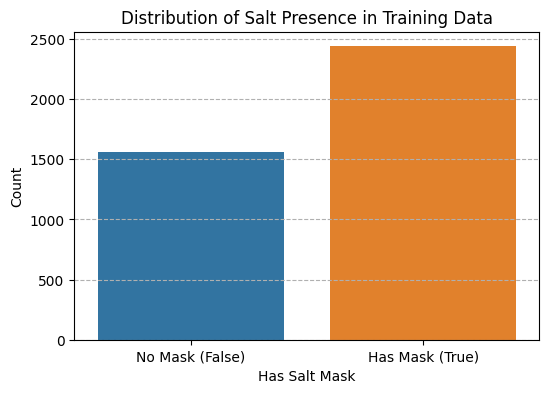

In [12]:
# --- 4b.2: Distribution of Salt Presence ---
print("\n--- Analyzing Salt Presence Distribution ---")
# Check if 'rle_mask' column exists and handle potential NaN values for calculation
if 'rle_mask' in train_df.columns:
    train_df['has_mask'] = train_df['rle_mask'].notna()
    salt_distribution = train_df['has_mask'].value_counts(normalize=True) * 100
    print("\nPercentage of images with/without salt masks:")
    print(salt_distribution)

    plt.figure(figsize=(6, 4))
    sns.countplot(data=train_df, x='has_mask')
    plt.title('Distribution of Salt Presence in Training Data')
    plt.xlabel('Has Salt Mask')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No Mask (False)', 'Has Mask (True)'])
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("Warning: 'rle_mask' column not found in train_df. Cannot analyze salt distribution.")
    train_df['has_mask'] = False 


--- Visualizing Sample Images and Masks ---
Displaying sample images with and without masks:


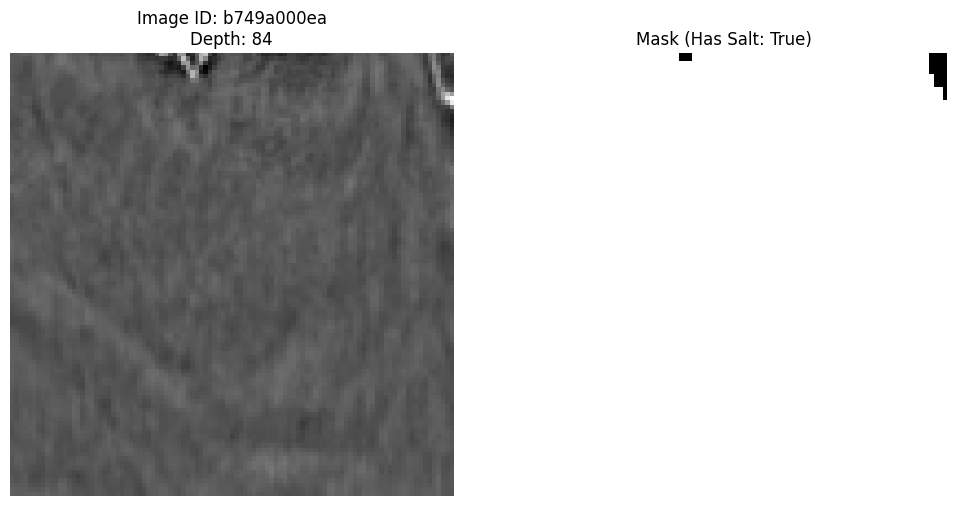

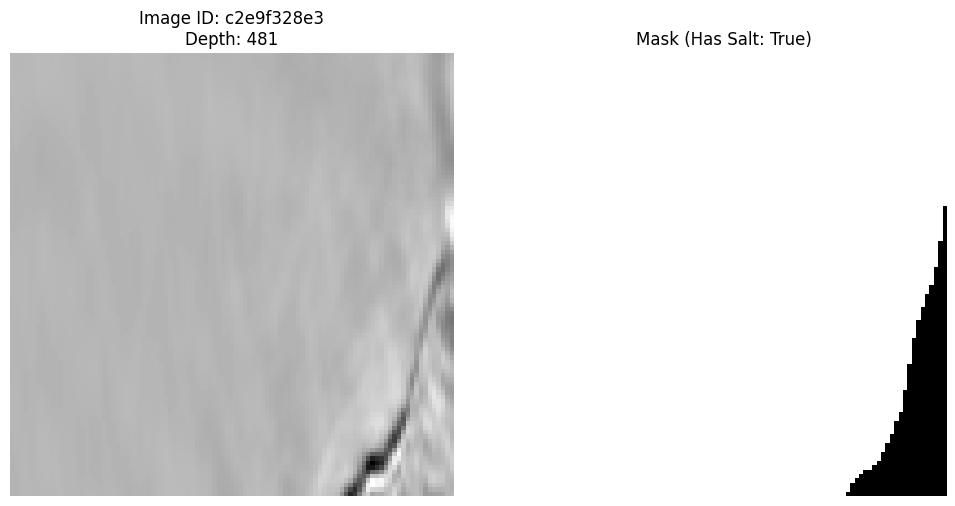

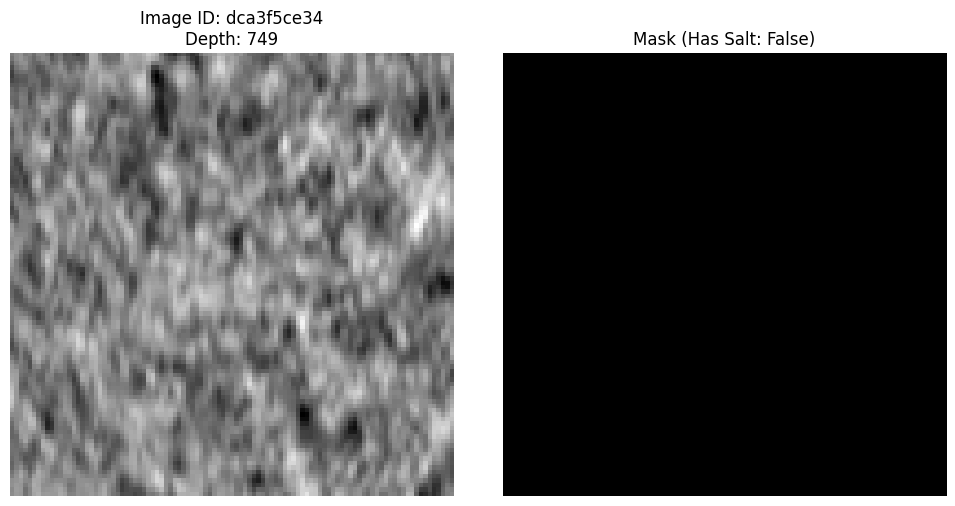

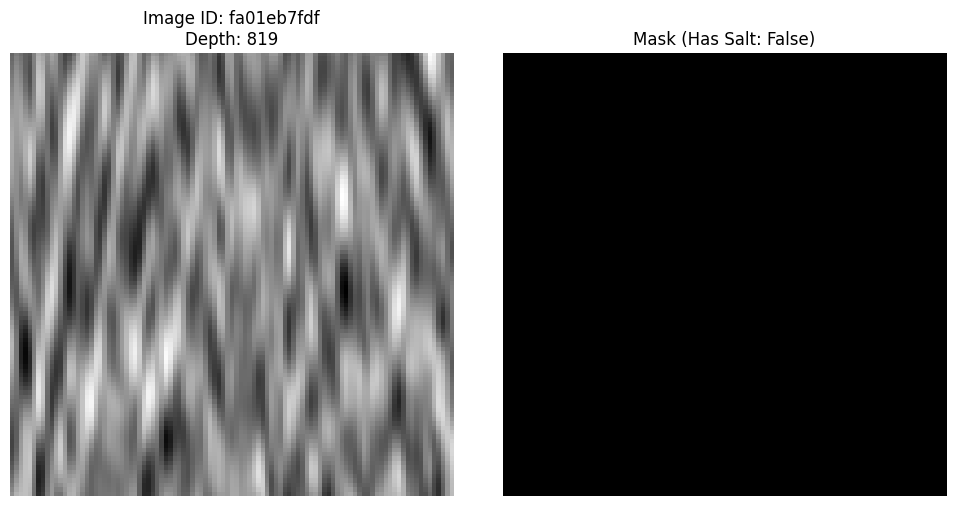

In [13]:
# --- 4b.3: Visualize Sample Images and Masks ---
print("\n--- Visualizing Sample Images and Masks ---")

def rle_decode(mask_rle, shape=(101, 101)):
    """
    Decodes a run-length encoded mask string into a numpy array.
    Args:
        mask_rle (str): Run-length encoding string.
        shape (tuple): Desired output shape (height, width).
    Returns:
        np.array: Decoded mask as a 2D numpy array.
    """
    if pd.isna(mask_rle): 
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape).T 

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1 # Adjust to 0-based indexing
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1 
    return img.reshape(shape).T 

def plot_sample(img_id, img_dir=TRAIN_IMAGE_DIR, mask_df=train_df):
    """Plots an image and its corresponding mask."""
    img_path = os.path.join(img_dir, f"{img_id}.png")
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return

    img = cv2.imread(img_path) # Load image in BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for plotting

    mask_rle = mask_df.loc[mask_df['id'] == img_id, 'rle_mask'].iloc[0] if 'rle_mask' in mask_df.columns and not mask_df[mask_df['id'] == img_id].empty else np.nan
    mask = rle_decode(mask_rle)

    depth = mask_df.loc[mask_df['id'] == img_id, 'z'].iloc[0] if 'z' in mask_df.columns and not mask_df[mask_df['id'] == img_id].empty else 'N/A'
    has_mask = mask.sum() > 0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title(f'Image ID: {img_id}\nDepth: {depth}')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f'Mask (Has Salt: {has_mask})')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Plot a few samples (if train_ids exist)
if train_ids:
    print("Displaying sample images with and without masks:")
    # Find samples with and without masks
    ids_with_mask = train_df[train_df['has_mask']]['id'].tolist()
    ids_without_mask = train_df[~train_df['has_mask']]['id'].tolist()

    sample_ids_to_plot = []
    if len(ids_with_mask) >= 2:
        sample_ids_to_plot.extend(random.sample(ids_with_mask, 2))
    elif ids_with_mask:
         sample_ids_to_plot.extend(ids_with_mask)

    if len(ids_without_mask) >= 2:
        sample_ids_to_plot.extend(random.sample(ids_without_mask, 2))
    elif ids_without_mask:
         sample_ids_to_plot.extend(ids_without_mask)

    # Ensure we only plot IDs that are actually in our train_ids list (after split)
    valid_sample_ids = [sid for sid in sample_ids_to_plot if sid in train_ids]

    for sample_id in valid_sample_ids[:4]: # Plot up to 4 samples
        plot_sample(sample_id)
else:
    print("Skipping sample visualization as no training IDs were found.")


--- Analyzing Depth Distribution ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

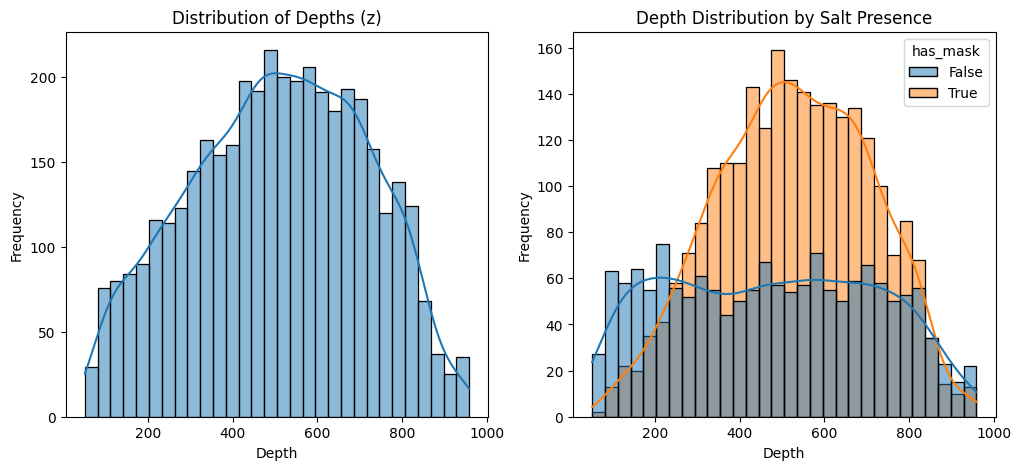

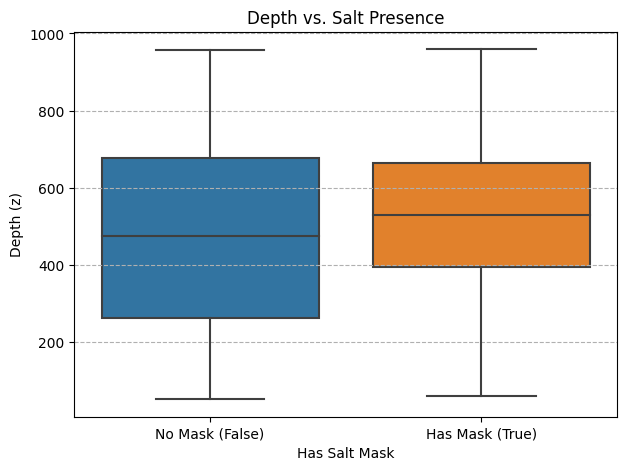

In [14]:
# --- 4b.4: Explore Depth Distribution and Relationship with Salt ---
print("\n--- Analyzing Depth Distribution ---")
if 'z' in train_df.columns and train_df['z'].notna().any():
    # Convert any infinities to NaN before plotting
    train_df_clean = train_df.copy()
    train_df_clean['z'] = train_df_clean['z'].replace([np.inf, -np.inf], np.nan)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(train_df_clean['z'], kde=True, bins=30)
    plt.title('Distribution of Depths (z)')
    plt.xlabel('Depth')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_df_clean, x='z', hue='has_mask', kde=True, bins=30)
    plt.title('Depth Distribution by Salt Presence')
    plt.xlabel('Depth')
    plt.ylabel('Frequency')
   


    
    # Box plot for depth vs salt presence
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=train_df_clean, x='has_mask', y='z')
    plt.title('Depth vs. Salt Presence')
    plt.xlabel('Has Salt Mask')
    plt.ylabel('Depth (z)')
    plt.xticks([0, 1], ['No Mask (False)', 'Has Mask (True)'])
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("Warning: 'z' column (depth) not found or contains all NaNs. Cannot analyze depth distribution.")


--- Analyzing Mask Coverage ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


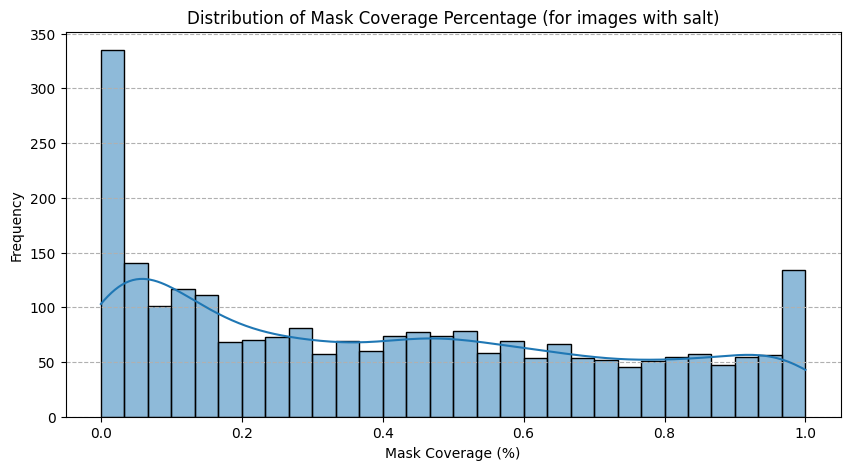

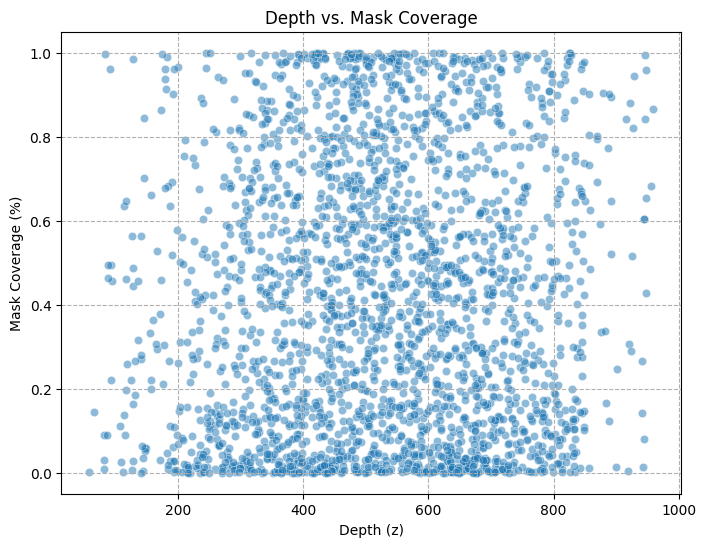

In [15]:
# --- 4b.5: Analyze Mask Coverage ---
print("\n--- Analyzing Mask Coverage ---")
if 'has_mask' in train_df.columns and train_df['has_mask'].any():
    # Calculate mask coverage percentage for images that have masks
    def get_mask_coverage(mask_rle, shape=(101, 101)):
        mask = rle_decode(mask_rle, shape)
        return mask.sum() / (shape[0] * shape[1])

    # Apply only to rows with masks to avoid decoding NaNs repeatedly
    train_df_with_mask = train_df[train_df['has_mask']].copy()
    if not train_df_with_mask.empty:
        train_df_with_mask['coverage'] = train_df_with_mask['rle_mask'].apply(get_mask_coverage)

        plt.figure(figsize=(10, 5))
        sns.histplot(train_df_with_mask['coverage'], kde=True, bins=30)
        plt.title('Distribution of Mask Coverage Percentage (for images with salt)')
        plt.xlabel('Mask Coverage (%)')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--')
        plt.show()

        # Relationship between depth and coverage
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=train_df_with_mask, x='z', y='coverage', alpha=0.5)
        plt.title('Depth vs. Mask Coverage')
        plt.xlabel('Depth (z)')
        plt.ylabel('Mask Coverage (%)')
        plt.grid(linestyle='--')
        plt.show()
    else:
        print("No images with masks found to analyze coverage.")
else:
    print("Warning: 'has_mask' column not found or no images have masks. Cannot analyze mask coverage.")

In [56]:
# ===========================================
# Step 5: Define SaltDataset and Create DataLoaders
# ===========================================
class SaltDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, transform=None, is_test=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.is_test:
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            image_id = os.path.basename(image_path).split('.')[0]
            return image, image_id
        else:
            mask_path = self.mask_paths[idx]
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None: 
                mask = np.zeros((101, 101), dtype=np.uint8) 

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            if mask.ndim == 2:
                 mask = mask.unsqueeze(0)
            mask = mask.float() / 255.0
            return image, mask

# --- Create Datasets ---
train_dataset = SaltDataset(train_images, train_masks, transform=train_transform)
val_dataset = SaltDataset(val_images, val_masks, transform=val_transform)
test_dataset = SaltDataset(test_image_paths, mask_paths=None, transform=val_transform, is_test=True)

# --- Create DataLoaders ---
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True) # drop_last helps with batch norm stability
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Datasets and DataLoaders are ready!")

Datasets and DataLoaders are ready!


In [57]:
# ===========================================
# Step 6: IoU Metric and Train/Validate Loop
# ===========================================
def compute_iou(preds, targets, threshold=0.5, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds_binary = (preds > threshold).float()
    targets_binary = (targets > 0.5).float()
    intersection = (preds_binary * targets_binary).sum(dim=(1, 2, 3))
    union = (preds_binary + targets_binary).sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def train_validate_epoch(model, train_loader, val_loader, optimizer, criterion, device, scheduler=None):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_pbar = tqdm(train_loader, desc="Training", leave=False)
    for images, masks in train_pbar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        batch_iou = compute_iou(outputs.detach(), masks).item()
        train_loss += batch_loss
        train_iou += batch_iou
        train_pbar.set_postfix(loss=f"{batch_loss:.4f}", iou=f"{batch_iou:.4f}")
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_pbar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for images, masks in val_pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            batch_loss = loss.item()
            batch_iou = compute_iou(outputs, masks).item()
            val_loss += batch_loss
            val_iou += batch_iou
            val_pbar.set_postfix(loss=f"{batch_loss:.4f}", iou=f"{batch_iou:.4f}")
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    # --- Scheduler Step ---
    if scheduler:
         scheduler.step(avg_val_loss)

    return avg_train_loss, avg_train_iou, avg_val_loss, avg_val_iou

print("Metrics and Train/Validate loop defined.")

Metrics and Train/Validate loop defined.


In [58]:
# ===========================================
# Step 7: Training Configuration and Execution - Loop through Experiments
# ===========================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# --- Define Experiment Configurations ---
configurations = [
    {'backbone': 'resnet34', 'loss_fn_name': 'ComboLoss'},
    {'backbone': 'resnet34', 'loss_fn_name': 'Lovasz'},
    {'backbone': 'resnet50', 'loss_fn_name': 'ComboLoss'},
    {'backbone': 'resnet50', 'loss_fn_name': 'Lovasz'},
]

all_histories = {}
best_model_metrics = {}

# --- Create Directories ---
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# --- Loop Through Configurations ---
for config in configurations:
    backbone_name = config['backbone']
    loss_fn_name = config['loss_fn_name']
    config_name = f"{backbone_name}_{loss_fn_name}" 

    print(f"\n===== Starting Experiment: {config_name} =====")
    start_time = time.time()

    # --- Setup Model, Optimizer, Criterion, Scheduler ---
    set_seed(SEED) 
    model = UNet(backbone_name=backbone_name, pretrained=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    if loss_fn_name == 'ComboLoss':
        criterion = ComboLoss().to(DEVICE)
    elif loss_fn_name == 'Lovasz':
        criterion = LovaszLoss().to(DEVICE)
    else:
        raise ValueError("Unsupported loss function")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True) # Schedule based on Val IoU

    # --- Training Loop for this Configuration ---
    current_best_val_iou = 0.0
    current_best_epoch = 0
    history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"--- Epoch {epoch}/{NUM_EPOCHS} ({config_name}) ---")
        train_loss, train_iou, val_loss, val_iou = train_validate_epoch(
            model, train_loader, val_loader, optimizer, criterion, DEVICE, scheduler=None # Step scheduler manually based on IoU
        )

        # Store history
        history['train_loss'].append(train_loss)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        print(f"Epoch {epoch} Summary - Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f} | Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")


        scheduler.step(val_iou)

        # Save the best model for this configuration
        if val_iou > current_best_val_iou:
            current_best_val_iou = val_iou
            current_best_epoch = epoch
            model_save_path = f"models/best_model_{config_name}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"✨ Best model for {config_name} saved to {model_save_path} (Val IoU: {current_best_val_iou:.4f})")

    end_time = time.time()
    print(f"--- Experiment {config_name} Finished ---")
    print(f"Best Validation IoU: {current_best_val_iou:.4f} at Epoch {current_best_epoch}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Store results for this configuration
    all_histories[config_name] = history
    best_model_metrics[config_name] = {'best_val_iou': current_best_val_iou, 'best_epoch': current_best_epoch}

Using device: cuda

===== Starting Experiment: resnet34_ComboLoss =====
--- Epoch 1/20 (resnet34_ComboLoss) ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Summary - Train Loss: 1.0533, Train IoU: 0.4896 | Val Loss: 0.7913, Val IoU: 0.6459
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.6459)
--- Epoch 2/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Summary - Train Loss: 0.7675, Train IoU: 0.6463 | Val Loss: 0.5824, Val IoU: 0.7259
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7259)
--- Epoch 3/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Summary - Train Loss: 0.6509, Train IoU: 0.6947 | Val Loss: 0.5639, Val IoU: 0.7420
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7420)
--- Epoch 4/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Summary - Train Loss: 0.5964, Train IoU: 0.7187 | Val Loss: 0.5005, Val IoU: 0.7657
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7657)
--- Epoch 5/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Summary - Train Loss: 0.5676, Train IoU: 0.7313 | Val Loss: 0.4877, Val IoU: 0.7623
--- Epoch 6/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Summary - Train Loss: 0.5272, Train IoU: 0.7464 | Val Loss: 0.4628, Val IoU: 0.7765
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7765)
--- Epoch 7/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Summary - Train Loss: 0.5148, Train IoU: 0.7549 | Val Loss: 0.4895, Val IoU: 0.7718
--- Epoch 8/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Summary - Train Loss: 0.4921, Train IoU: 0.7669 | Val Loss: 0.4591, Val IoU: 0.7993
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.7993)
--- Epoch 9/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Summary - Train Loss: 0.4740, Train IoU: 0.7765 | Val Loss: 0.4666, Val IoU: 0.7951
--- Epoch 10/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Summary - Train Loss: 0.4835, Train IoU: 0.7708 | Val Loss: 0.4134, Val IoU: 0.7983
--- Epoch 11/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Summary - Train Loss: 0.4500, Train IoU: 0.7784 | Val Loss: 0.4103, Val IoU: 0.8013
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.8013)
--- Epoch 12/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Summary - Train Loss: 0.4291, Train IoU: 0.7881 | Val Loss: 0.4325, Val IoU: 0.8050
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.8050)
--- Epoch 13/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Summary - Train Loss: 0.4305, Train IoU: 0.7946 | Val Loss: 0.3829, Val IoU: 0.8151
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.8151)
--- Epoch 14/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Summary - Train Loss: 0.4314, Train IoU: 0.7898 | Val Loss: 0.3831, Val IoU: 0.8018
--- Epoch 15/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Summary - Train Loss: 0.4124, Train IoU: 0.7946 | Val Loss: 0.4263, Val IoU: 0.8052
--- Epoch 16/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Summary - Train Loss: 0.4088, Train IoU: 0.8028 | Val Loss: 0.4229, Val IoU: 0.8223
✨ Best model for resnet34_ComboLoss saved to models/best_model_resnet34_ComboLoss.pth (Val IoU: 0.8223)
--- Epoch 17/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Summary - Train Loss: 0.4175, Train IoU: 0.7983 | Val Loss: 0.4006, Val IoU: 0.8073
--- Epoch 18/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Summary - Train Loss: 0.3993, Train IoU: 0.8038 | Val Loss: 0.3699, Val IoU: 0.8165
--- Epoch 19/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Summary - Train Loss: 0.4142, Train IoU: 0.8013 | Val Loss: 0.4055, Val IoU: 0.8095
--- Epoch 20/20 (resnet34_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Summary - Train Loss: 0.3966, Train IoU: 0.8022 | Val Loss: 0.3804, Val IoU: 0.8161
--- Experiment resnet34_ComboLoss Finished ---
Best Validation IoU: 0.8223 at Epoch 16
Time taken: 248.89 seconds

===== Starting Experiment: resnet34_Lovasz =====
--- Epoch 1/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Summary - Train Loss: 0.9587, Train IoU: 0.4393 | Val Loss: 0.7789, Val IoU: 0.5942
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.5942)
--- Epoch 2/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Summary - Train Loss: 0.8122, Train IoU: 0.5603 | Val Loss: 0.7429, Val IoU: 0.6400
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.6400)
--- Epoch 3/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Summary - Train Loss: 0.7623, Train IoU: 0.5849 | Val Loss: 0.6649, Val IoU: 0.6073
--- Epoch 4/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Summary - Train Loss: 0.6945, Train IoU: 0.5991 | Val Loss: 0.5912, Val IoU: 0.6502
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.6502)
--- Epoch 5/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Summary - Train Loss: 0.6374, Train IoU: 0.6363 | Val Loss: 0.5497, Val IoU: 0.6939
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.6939)
--- Epoch 6/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Summary - Train Loss: 0.5961, Train IoU: 0.6582 | Val Loss: 0.5172, Val IoU: 0.7033
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7033)
--- Epoch 7/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Summary - Train Loss: 0.5741, Train IoU: 0.6572 | Val Loss: 0.4973, Val IoU: 0.6964
--- Epoch 8/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Summary - Train Loss: 0.5944, Train IoU: 0.6587 | Val Loss: 0.4695, Val IoU: 0.7196
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7196)
--- Epoch 9/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Summary - Train Loss: 0.5623, Train IoU: 0.6732 | Val Loss: 0.4703, Val IoU: 0.7330
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7330)
--- Epoch 10/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Summary - Train Loss: 0.5458, Train IoU: 0.6975 | Val Loss: 0.4733, Val IoU: 0.7193
--- Epoch 11/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Summary - Train Loss: 0.5479, Train IoU: 0.6828 | Val Loss: 0.4240, Val IoU: 0.7498
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7498)
--- Epoch 12/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Summary - Train Loss: 0.5185, Train IoU: 0.6966 | Val Loss: 0.4435, Val IoU: 0.7317
--- Epoch 13/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Summary - Train Loss: 0.5369, Train IoU: 0.6846 | Val Loss: 0.4303, Val IoU: 0.7644
✨ Best model for resnet34_Lovasz saved to models/best_model_resnet34_Lovasz.pth (Val IoU: 0.7644)
--- Epoch 14/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Summary - Train Loss: 0.5364, Train IoU: 0.6860 | Val Loss: 0.4484, Val IoU: 0.7046
--- Epoch 15/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Summary - Train Loss: 0.5619, Train IoU: 0.6541 | Val Loss: 0.4513, Val IoU: 0.7223
--- Epoch 16/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Summary - Train Loss: 0.5806, Train IoU: 0.6597 | Val Loss: 0.5187, Val IoU: 0.7189
--- Epoch 17/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Summary - Train Loss: 0.5472, Train IoU: 0.6705 | Val Loss: 0.4921, Val IoU: 0.6841
--- Epoch 18/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Summary - Train Loss: 0.5681, Train IoU: 0.6610 | Val Loss: 0.4736, Val IoU: 0.7044
--- Epoch 19/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Summary - Train Loss: 0.5624, Train IoU: 0.6625 | Val Loss: 0.4717, Val IoU: 0.7281
--- Epoch 20/20 (resnet34_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Summary - Train Loss: 0.5189, Train IoU: 0.6862 | Val Loss: 0.4441, Val IoU: 0.7310
--- Experiment resnet34_Lovasz Finished ---
Best Validation IoU: 0.7644 at Epoch 13
Time taken: 244.68 seconds

===== Starting Experiment: resnet50_ComboLoss =====
--- Epoch 1/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Summary - Train Loss: 0.9482, Train IoU: 0.5492 | Val Loss: 0.6657, Val IoU: 0.6890
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.6890)
--- Epoch 2/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Summary - Train Loss: 0.6832, Train IoU: 0.6746 | Val Loss: 0.5824, Val IoU: 0.7279
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7279)
--- Epoch 3/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Summary - Train Loss: 0.6234, Train IoU: 0.7086 | Val Loss: 0.5052, Val IoU: 0.7533
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7533)
--- Epoch 4/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Summary - Train Loss: 0.5622, Train IoU: 0.7357 | Val Loss: 0.4732, Val IoU: 0.7724
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7724)
--- Epoch 5/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Summary - Train Loss: 0.5367, Train IoU: 0.7453 | Val Loss: 0.4398, Val IoU: 0.7818
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7818)
--- Epoch 6/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Summary - Train Loss: 0.5141, Train IoU: 0.7601 | Val Loss: 0.4342, Val IoU: 0.7868
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.7868)
--- Epoch 7/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Summary - Train Loss: 0.4933, Train IoU: 0.7666 | Val Loss: 0.4194, Val IoU: 0.8002
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8002)
--- Epoch 8/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Summary - Train Loss: 0.4604, Train IoU: 0.7816 | Val Loss: 0.3972, Val IoU: 0.8057
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8057)
--- Epoch 9/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Summary - Train Loss: 0.4583, Train IoU: 0.7777 | Val Loss: 0.4054, Val IoU: 0.8060
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8060)
--- Epoch 10/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Summary - Train Loss: 0.4228, Train IoU: 0.7958 | Val Loss: 0.4172, Val IoU: 0.8056
--- Epoch 11/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Summary - Train Loss: 0.4217, Train IoU: 0.7973 | Val Loss: 0.3899, Val IoU: 0.8143
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8143)
--- Epoch 12/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Summary - Train Loss: 0.4227, Train IoU: 0.7985 | Val Loss: 0.3727, Val IoU: 0.8234
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8234)
--- Epoch 13/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Summary - Train Loss: 0.3975, Train IoU: 0.8064 | Val Loss: 0.3765, Val IoU: 0.8131
--- Epoch 14/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Summary - Train Loss: 0.3960, Train IoU: 0.8030 | Val Loss: 0.3711, Val IoU: 0.8224
--- Epoch 15/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Summary - Train Loss: 0.4066, Train IoU: 0.8049 | Val Loss: 0.3729, Val IoU: 0.8210
--- Epoch 16/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Summary - Train Loss: 0.3792, Train IoU: 0.8150 | Val Loss: 0.3476, Val IoU: 0.8279
✨ Best model for resnet50_ComboLoss saved to models/best_model_resnet50_ComboLoss.pth (Val IoU: 0.8279)
--- Epoch 17/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Summary - Train Loss: 0.3759, Train IoU: 0.8165 | Val Loss: 0.3649, Val IoU: 0.8215
--- Epoch 18/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Summary - Train Loss: 0.3668, Train IoU: 0.8179 | Val Loss: 0.3909, Val IoU: 0.8191
--- Epoch 19/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Summary - Train Loss: 0.3722, Train IoU: 0.8153 | Val Loss: 0.3919, Val IoU: 0.8250
--- Epoch 20/20 (resnet50_ComboLoss) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Summary - Train Loss: 0.3676, Train IoU: 0.8197 | Val Loss: 0.3566, Val IoU: 0.8273
--- Experiment resnet50_ComboLoss Finished ---
Best Validation IoU: 0.8279 at Epoch 16
Time taken: 691.00 seconds

===== Starting Experiment: resnet50_Lovasz =====
--- Epoch 1/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Summary - Train Loss: 0.9558, Train IoU: 0.4922 | Val Loss: 0.6900, Val IoU: 0.6683
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.6683)
--- Epoch 2/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Summary - Train Loss: 0.7034, Train IoU: 0.6663 | Val Loss: 0.5543, Val IoU: 0.7295
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7295)
--- Epoch 3/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Summary - Train Loss: 0.6172, Train IoU: 0.7025 | Val Loss: 0.5312, Val IoU: 0.7549
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7549)
--- Epoch 4/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Summary - Train Loss: 0.5746, Train IoU: 0.7217 | Val Loss: 0.4637, Val IoU: 0.7777
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7777)
--- Epoch 5/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Summary - Train Loss: 0.5289, Train IoU: 0.7451 | Val Loss: 0.4562, Val IoU: 0.7826
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7826)
--- Epoch 6/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Summary - Train Loss: 0.5099, Train IoU: 0.7551 | Val Loss: 0.4511, Val IoU: 0.7890
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7890)
--- Epoch 7/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Summary - Train Loss: 0.5136, Train IoU: 0.7543 | Val Loss: 0.4635, Val IoU: 0.7821
--- Epoch 8/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Summary - Train Loss: 0.4688, Train IoU: 0.7722 | Val Loss: 0.4064, Val IoU: 0.7993
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.7993)
--- Epoch 9/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Summary - Train Loss: 0.4634, Train IoU: 0.7757 | Val Loss: 0.4081, Val IoU: 0.8021
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8021)
--- Epoch 10/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Summary - Train Loss: 0.4461, Train IoU: 0.7835 | Val Loss: 0.4138, Val IoU: 0.7981
--- Epoch 11/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Summary - Train Loss: 0.4578, Train IoU: 0.7746 | Val Loss: 0.3974, Val IoU: 0.8057
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8057)
--- Epoch 12/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Summary - Train Loss: 0.4389, Train IoU: 0.7840 | Val Loss: 0.3809, Val IoU: 0.8071
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8071)
--- Epoch 13/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Summary - Train Loss: 0.4345, Train IoU: 0.7881 | Val Loss: 0.3920, Val IoU: 0.8056
--- Epoch 14/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Summary - Train Loss: 0.4378, Train IoU: 0.7783 | Val Loss: 0.4102, Val IoU: 0.7914
--- Epoch 15/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Summary - Train Loss: 0.4418, Train IoU: 0.7819 | Val Loss: 0.3818, Val IoU: 0.8084
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8084)
--- Epoch 16/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Summary - Train Loss: 0.4399, Train IoU: 0.7839 | Val Loss: 0.4038, Val IoU: 0.8005
--- Epoch 17/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Summary - Train Loss: 0.4299, Train IoU: 0.7886 | Val Loss: 0.3813, Val IoU: 0.8114
✨ Best model for resnet50_Lovasz saved to models/best_model_resnet50_Lovasz.pth (Val IoU: 0.8114)
--- Epoch 18/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Summary - Train Loss: 0.4352, Train IoU: 0.7846 | Val Loss: 0.4046, Val IoU: 0.8019
--- Epoch 19/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Summary - Train Loss: 0.4333, Train IoU: 0.7857 | Val Loss: 0.3967, Val IoU: 0.8032
--- Epoch 20/20 (resnet50_Lovasz) ---


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Summary - Train Loss: 0.4148, Train IoU: 0.7898 | Val Loss: 0.3876, Val IoU: 0.7983
--- Experiment resnet50_Lovasz Finished ---
Best Validation IoU: 0.8114 at Epoch 17
Time taken: 687.57 seconds



--- Generating Comparison Plot ---


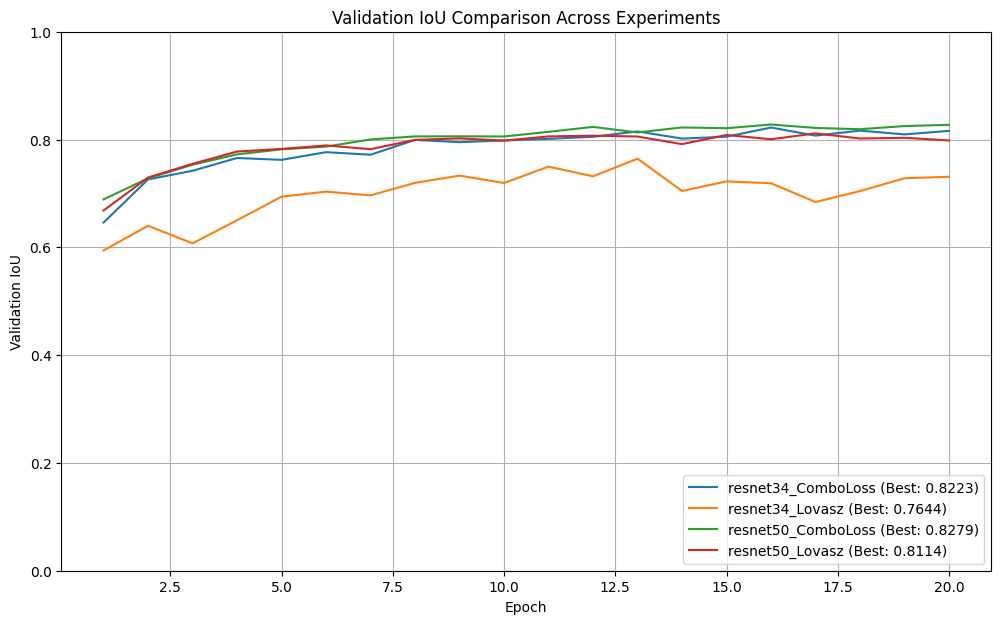

Comparison plot saved to results/validation_iou_comparison.png


In [59]:
# ===========================================
# Step 7b: Comparison Plotting
# ===========================================
print("\n--- Generating Comparison Plot ---")
plt.figure(figsize=(12, 7))

for config_name, history in all_histories.items():
    epochs_range = range(1, len(history['val_iou']) + 1)
    plt.plot(epochs_range, history['val_iou'], label=f"{config_name} (Best: {best_model_metrics[config_name]['best_val_iou']:.4f})")

plt.title('Validation IoU Comparison Across Experiments')
plt.xlabel('Epoch')
plt.ylabel('Validation IoU')
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0, 1) # Set y-axis limits for IoU
plt.savefig("results/validation_iou_comparison.png")
plt.show()
print("Comparison plot saved to results/validation_iou_comparison.png")

In [60]:
# ===========================================
# Step 8: Prediction and Submission File Generation (Using Overall Best Model)
# ===========================================

# --- Find the Overall Best Model ---
overall_best_iou = -1.0
best_config_name = None
for config_name, metrics in best_model_metrics.items():
    if metrics['best_val_iou'] > overall_best_iou:
        overall_best_iou = metrics['best_val_iou']
        best_config_name = config_name

print(f"\n--- Overall Best Model based on Validation IoU: {best_config_name} (IoU: {overall_best_iou:.4f}) ---")

# --- Run-Length Encoding Function ---
def rle_encode(img):
    pixels = img.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# --- Prediction Function ---
def predict_test(model, test_loader, device, threshold=0.5):
    model.eval()
    predictions = {}
    test_pbar = tqdm(test_loader, desc="Predicting", leave=False)
    with torch.no_grad():
        for images, image_ids in test_pbar:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            probs_resized = F.interpolate(probs, size=(101, 101), mode='bilinear', align_corners=False)
            preds_binary = (probs_resized > threshold).cpu().numpy().astype(np.uint8)
            for i, img_id in enumerate(image_ids):
                 pred_mask = preds_binary[i].squeeze()
                 predictions[img_id] = pred_mask
    return predictions

# --- Load the Overall Best Model ---
# Re-instantiate the model architecture for the best config
best_backbone = best_config_name.split('_')[0]
best_model = UNet(backbone_name=best_backbone, pretrained=False).to(DEVICE) # No need for pretrained weights now

best_model_path = f"models/best_model_{best_config_name}.pth"
if os.path.exists(best_model_path):
    print(f"Loading overall best model from: {best_model_path}")
    best_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
else:
    print(f"Error: Best model path not found ({best_model_path}). Cannot generate submission.")
    # Handle error appropriately, maybe exit or use a default model if available

# --- Perform Prediction with Best Model ---
if os.path.exists(best_model_path):
    test_predictions = predict_test(best_model, test_loader, DEVICE, threshold=0.5) # Adjust threshold if needed

    # --- Generate Submission File ---
    submission_data = []
    for img_id in tqdm(test_ids, desc="Encoding"): # Use sorted test_ids
        if img_id in test_predictions:
            rle = rle_encode(test_predictions[img_id])
        else:
            rle = ''
            print(f"Warning: Prediction missing for image ID: {img_id}")
        submission_data.append({'id': img_id, 'rle_mask': rle})

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv('submission.csv', index=False)

    print("\n--- Submission File Generated: submission.csv ---")
    print(submission_df.head())
else:
    print("Submission file not generated due to missing best model.")


--- Overall Best Model based on Validation IoU: resnet50_ComboLoss (IoU: 0.8279) ---
Loading overall best model from: models/best_model_resnet50_ComboLoss.pth


/tmp/ipykernel_31/63944350.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))


Predicting:   0%|          | 0/563 [00:00<?, ?it/s]

Encoding:   0%|          | 0/18000 [00:00<?, ?it/s]


--- Submission File Generated: submission.csv ---
           id                                           rle_mask
0  0005bb9630  30 72 131 72 231 73 332 73 432 74 532 75 633 7...
1  000a68e46c                                                   
2  000c8dfb2a                                                   
3  000d0a5f6c                                                   
4  001ef8fc87  1 7366 7374 79 7475 71 7576 67 7677 63 7778 58...


In [61]:

print("\nZipping output files...")
if os.path.exists("models"):
    !zip -rq models.zip /kaggle/working/models # Use -q for quiet, -r for recursive
    print("models.zip created.")
if os.path.exists("results"):
    !zip -rq results.zip /kaggle/working/results
    print("results.zip created.")

print("\n--- Script Finished ---")


Zipping output files...
models.zip created.
results.zip created.

--- Script Finished ---
